<a href="https://colab.research.google.com/github/srGOLD78/srGOLD78.github.io/blob/main/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn
seaborn.set(palette='viridis')

In [3]:
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor()])


train_data = datasets.CIFAR10(root='./data', train=True,
                        download=True, transform=transform)

test_data = datasets.CIFAR10(root='./data', train=False,
                        download=True, transform=transform)

train_load = DataLoader(train_data, batch_size=batch_size,
                        shuffle=True, num_workers=2 , drop_last=True)

test_load = DataLoader(test_data, batch_size=batch_size,
                        shuffle=False, num_workers=2 ,drop_last=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 38384856.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3 , padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3 ,padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3,padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.linear1 = nn.Linear(256*6*6 , 256*6)
        self.fn_ac = nn.ReLU6()
        self.linear2 = nn.Linear(256*6 , 256*6)
        self.linear3 = nn.Linear(256*6 , 10)
        self.dr_out = nn.Dropout(0.3)




    def forward(self, x):
        out =  self.layer1(x)
        out =  self.layer2(out)
        out =  self.layer3(out)
        out =  self.layer4(out)
        #print(out.shape)

        out = out.reshape(out.size(0), -1)

        out =  self.linear1(out)
        out =  self.dr_out(out)
        out =  self.fn_ac(out)

        out =  self.linear2(out)
        out =  self.dr_out(out)
        out =  self.fn_ac(out)

        out =  self.linear3(out)

        return out

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
lr = 0.0003
num_epochs = 10
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters() , lr = lr)

In [7]:
loss_list = []
acc_list = []

In [8]:
for epoch in range(num_epochs):
    model.train()
    loss_epoch_train = []
    acc_epoch_train = []

    for images, labels in train_load:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)
        loss = loss_fn( outputs, labels )

        acc_epoch_train.append((torch.as_tensor(([i.argmax() for i in outputs])).to(device) == labels).int().sum().item()/len(labels))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch_train.append(loss.item())

    loss_list.append(sum(loss_epoch_train)/len(loss_epoch_train))
    acc_list.append(sum(acc_epoch_train)/len(acc_epoch_train))

    print(f" эпоха {epoch+1} loss_train:{loss_list[epoch]} acc_train = {acc_list[epoch]}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 эпоха 1 loss_train:1.3164675273132325 acc_train = 0.52482
 эпоха 2 loss_train:0.9694195800352097 acc_train = 0.6614
 эпоха 3 loss_train:0.8488239466762543 acc_train = 0.70436
 эпоха 4 loss_train:0.7694823172664642 acc_train = 0.73364
 эпоха 5 loss_train:0.7040549424743653 acc_train = 0.7566
 эпоха 6 loss_train:0.6449145858287811 acc_train = 0.77798
 эпоха 7 loss_train:0.5935473906946183 acc_train = 0.79696
 эпоха 8 loss_train:0.5410110360836983 acc_train = 0.81448
 эпоха 9 loss_train:0.4942369853770733 acc_train = 0.83122
 эпоха 10 loss_train:0.45521016822874544 acc_train = 0.842


In [9]:
class AE(nn.Module):
    def __init__(self , hiden_dim):
        super(AE,self).__init__()
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 11),
            nn.ReLU(inplace=True),


            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 7),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size = 5),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size = 3),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256,out_channels=256,kernel_size = 3),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256,out_channels=256,kernel_size = 3),
            nn.ReLU(inplace=True),


            )


        self.decoder = nn.Sequential(


            nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size = 3),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size = 3),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(in_channels=256 , out_channels=128,kernel_size=3,),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128 , out_channels=64,kernel_size=5,),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=7),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(in_channels=32,out_channels=3,kernel_size=11),
            nn.ReLU(inplace=True),


        )

        self.sig = nn.Sigmoid()


    def forward(self, x ):
        out =  self.encoder(x)
        out =  self.sig(self.decoder(out))
        return out


In [13]:
lr = 0.0003
num_epochs = 50
model = AE(128).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam( model.parameters() , lr = lr)

In [14]:
loss_train_list = []


In [15]:
for epoch in range(num_epochs):
    loss_epoch_train = []
    for images, labels in train_load:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch_train.append(loss.item())

    loss_train_list.append(sum(loss_epoch_train)/len(loss_epoch_train))



    print(f" эпоха {epoch+1} loss_train:{loss_train_list[epoch]}")


 эпоха 1 loss_train:0.661435972518921
 эпоха 2 loss_train:0.6479613914680481
 эпоха 3 loss_train:0.6436425975418091
 эпоха 4 loss_train:0.6415174585914611
 эпоха 5 loss_train:0.6399562067985535
 эпоха 6 loss_train:0.6388085243034363
 эпоха 7 loss_train:0.6379039890861511
 эпоха 8 loss_train:0.6371355284118653
 эпоха 9 loss_train:0.6364379404640198
 эпоха 10 loss_train:0.6358463436508178
 эпоха 11 loss_train:0.6354168155288696
 эпоха 12 loss_train:0.6348411381530762
 эпоха 13 loss_train:0.6345390292739869
 эпоха 14 loss_train:0.6341645670318603
 эпоха 15 loss_train:0.6338838886451721
 эпоха 16 loss_train:0.6335316844940185
 эпоха 17 loss_train:0.6332842107582092
 эпоха 18 loss_train:0.6331170902061463
 эпоха 19 loss_train:0.6328303189277649
 эпоха 20 loss_train:0.6326395535850525
 эпоха 21 loss_train:0.6323656566429138
 эпоха 22 loss_train:0.6323432288360595
 эпоха 23 loss_train:0.6321005434799194
 эпоха 24 loss_train:0.6319970669555665
 эпоха 25 loss_train:0.6317698487472534
 эпоха 26 

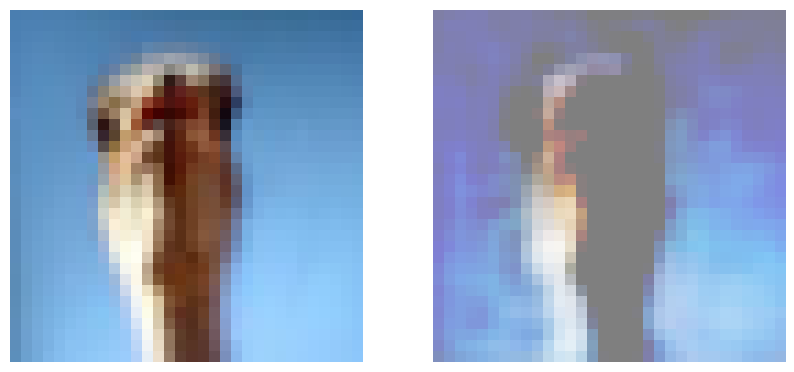

In [29]:
id = np.random.randint(0,10000)

with torch.no_grad():
    model.to('cpu')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Отображение первого изображения
    axs[0].imshow(test_data[id][0].permute(1,2,0))
    axs[0].axis('off')

    axs[1].imshow(model(test_data[id][0].unsqueeze(0)).squeeze(0).permute(1,2,0))
    axs[1].axis('off')

    # Показать изображения
    plt.show()

